In [1]:
import pandas as pd
from pathlib import Path
import pickle

from single import Wrapper, MLP

/home/sieverts/Developer/adadamp-experiments/exp-finetune/train.py


Plan:

1. visualize how important `[weight_decay, lr, dwell, momentum]` are
2. select some reasonable choices
3. then sweep over `initial_batch_size` and `max_batch_size`

DATA:

- `sweep0`: base sweep?
- `sweep1`: finished Mon. Jan. 13. trying to visualize `noisy`. That didn't work, but got a good idea of parameters and a new (smaller) sweep space.
- `sweep2`: finished Mon. Jan. 13 (evening). I think there was a bug in `sweep1`, I wasn't passing `noisy` in right. This fixes that. I got a much better idea of the search space with this, and now I'm curious to investigate `initial_batch_size`, `dwell` and `momentum`.
- `sweep3`. Finished running on 2025-10-14 @ 2:20pm.
    - I should be ready to choose parameters and implement PadaDamp (practical AdaDamp).
    - (after visualizing 597 runs) Looks good. Parameters below look good, reach a test loss of 1.2 after only ~60 epochs and ~100,000 model updates.

``` python
BASE = dict(lr=1e-3, momentum=0.6, dwell=1, weight_decay=1e-6,
            noisy=False, initial_batch_size=32)
```

- `sweep4`. Good run, but mistake with max_batch_size. Varied results with it, but should be a good viz otherwise. Finished Jan. 16 @ 10:00am.
    - `dwell=1` has best generalization, doesn't increase like other ones.

In [150]:
damper = "adadampnn"
# damper = "gd"
# damper = "adagrad"
damper = "geodamp"
damper = "geodamplr"
SEARCHES = Path(".") / "data-tuning" / "searches"
SEARCHES = Path(".") / "data-tuning" / "dampersearch"
searches = [pickle.loads(f.read_bytes()) for f in SEARCHES.glob(f"search-{damper}-*.pkl")]
print("Number of searches:", len(searches))
cv_results = pd.concat([pd.DataFrame(s.cv_results_) for s in searches]).reset_index()
print("Number of models:", len(cv_results))
print("Min test loss: {:0.2f}".format(-1 * cv_results.mean_test_score.max()))
# print("Number of models:", len(cv_results))

Number of searches: 25
Number of models: 625
Min test loss: 1.30


In [151]:
cv_results.tail()

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_damper,param_dwell,param_initial_batch_size,param_lr,param_max_batch_size,param_momentum,param_nesterov,param_weight_decay,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
620,20,258.456482,0.100799,0.000376,0.000007,geodamplr,2,256,0.030520,256,0.997927,True,0.000019,"{'damper': 'geodamplr', 'dwell': 2, 'initial_b...",-9.362632,-10.444912,-10.635520,-10.147688,0.560546,25
621,21,361.131336,62.660913,0.000342,0.000063,geodamplr,20,16,0.001684,256,0.988757,True,0.000002,"{'damper': 'geodamplr', 'dwell': 20, 'initial_...",-2.139576,-2.386331,-2.328050,-2.284652,0.105307,9
622,22,246.565915,54.728579,0.000336,0.000020,geodamplr,5,128,0.015440,1024,0.988406,True,0.000005,"{'damper': 'geodamplr', 'dwell': 5, 'initial_b...",-2.631870,-2.937578,-2.898434,-2.822627,0.135829,12
623,23,207.187688,54.311624,0.000331,0.000035,geodamplr,1,128,0.000185,512,0.915480,True,0.000002,"{'damper': 'geodamplr', 'dwell': 1, 'initial_b...",-3.958891,-3.959280,-3.968560,-3.962244,0.004469,20
624,24,359.426946,64.708969,0.000371,0.000075,geodamplr,20,16,0.000057,256,0.983516,True,0.000016,"{'damper': 'geodamplr', 'dwell': 20, 'initial_...",-2.253053,-2.266106,-2.302579,-2.273913,0.020959,8


# Visualizing param performance

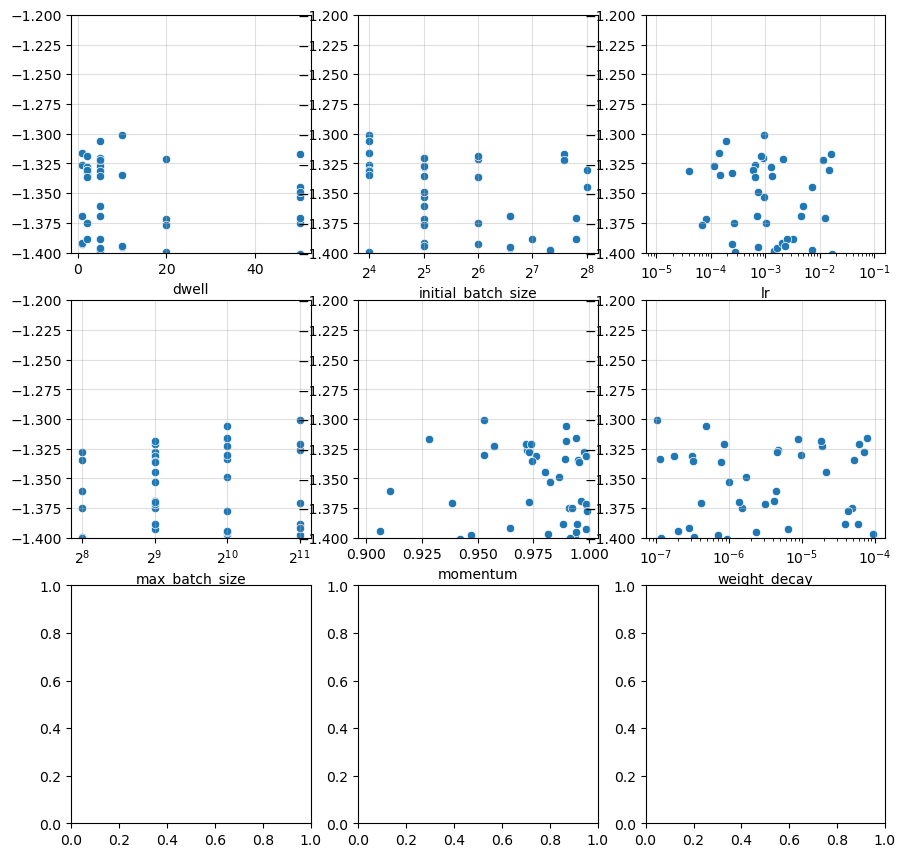

In [152]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

w = 3
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3.5 * w, 3.5 * w))

params = [c for c in cv_results.columns if "param_" in c]
params = [c for c in params if "damper" not in c and "nesterov" not in c and "reduction" not in c]
for c, ax in zip(params, axs.flatten()):
    ax = sns.scatterplot(
        x=c,
        y="mean_test_score",
        ax=ax,
        data=cv_results,
    )
    ax.set_xlabel(c.replace("param_", ""))
    ax.set_ylim(-1.4, -1.20)
    ax.grid(alpha=0.4)
    if "batch_size" in c:# or "dwell" in c: 
        ax.set_xscale("log", base=2)
    if "lr" in c or  "weight_decay" in c or "wait" in c:
        ax.set_xscale("log", base=10)
    ax.set_ylabel("")

# {
#     "dwell": loguniform(10, 50),
#     "initial_batch_size": [16, 32, 64, 96, 128],
#     # "lr": loguniform(1e-5, 1e-3),
#     "max_batch-size": [256, 512, 1024, 2048],
#     "momentum": uniform(1e-3, 0.8),
#     "reduction": ["min"],
#     # "rho": uniform(0, 0.99),
#     # "wait": loguniform(20, 1e3),
#     # "weight_decay": loguniform(1e-7, 1e-5),
# }

# Getting 5 best param combos

Text(0, 0.5, 'std_test_score')

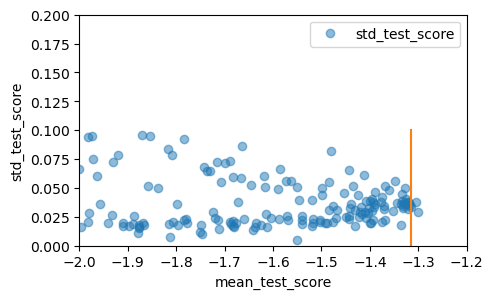

In [153]:
N_BEST = 3
high_mean = cv_results["mean_test_score"].nlargest(N_BEST).index
cutoff = cv_results.loc[high_mean, "mean_test_score"].min()
low_std = cv_results["std_test_score"].nsmallest(10).index

best_models = cv_results.loc[high_mean]

# best_models[[c for c in best_models.columns if "param" not in c]]
fig, ax = plt.subplots(figsize=(5, 3))
ax = cv_results.plot(
    x="mean_test_score",
    y="std_test_score",
    style="o", ax=ax,
    alpha=0.5,
)
ax.plot([cutoff, cutoff], [0, 0.1])
ax.set_ylim(0, 0.2)
ax.set_xlim(-2, -1.2)
ax.set_ylabel("std_test_score")

In [154]:
import numpy as np
def md5(x) -> str:
    import hashlib
    result = hashlib.md5(str(x).encode("ascii"))
    return result.digest().hex()

def clean(x):
    if isinstance(x, list):
        return [clean(i) for i in x]
    if isinstance(x, tuple):
        return tuple([clean(i) for i in x])
    if isinstance(x, dict):
        return {k: clean(v) for k, v in x.items()}
    if isinstance(x, (np.int32, np.int64, np.float64, np.float32)):
        return x.item()
    if isinstance(x, np.ndarray):
        return x.tolist()
    return x



In [155]:
SWEEPS = Path(".").absolute() / "data-tuning" / "dampersweep"
assert SWEEPS.exists()

dfs = {f.name.replace(".pkl.zip", ""): pd.read_pickle(f) for f in SWEEPS.glob("*.pkl.zip")}
print(len(dfs))
dfs = {k: df for k, df in dfs.items() if damper == df.iloc[0]["damper"]}
print(len(dfs))

13125
0


In [156]:
from typing import Tuple, List, Dict, Any

def same_params(row, params) -> float:
    str_params = [k for k, v in params.items() if isinstance(v, str)]
    bool_params = [k for k, v in params.items() if isinstance(v, bool)]
    num_params = [k for k in params if k not in str_params and k not in bool_params]
    diffs = {
        k: np.abs(row[k] - params[k]).astype(float).item() #/ np.abs(0.5 * (row[k] + params[k]))
        for k in num_params
    }

    same_bool = [bool(np.abs(int(row[k]) - int(params[k])) < 0.5) for k in bool_params]
    same_str = [bool(row[k] == params[k]) for k in str_params]
    if not all(same_str) or not all(same_bool):
        return 1e9
    return sum(diffs.values())

def _params_match(params: Dict[str, Any], est_params):
    failures = dict()
    for k, v in params.items():
        if isinstance(v, str) and params[k] != est_params[k]:
            failures[k] = (params[k], est_params[k])
        if isinstance(v, int) and np.abs(params[k] - est_params[k]) > 1e-3:
            failures[k] = (params[k], est_params[k])
        if isinstance(v, float) and not np.allclose(params[k], est_params[k]):
            failures[k] = (params[k], est_params[k])
    return not bool(len(failures))
    
def find_training_run(mparams, dfs) -> Tuple[str, List[pd.DataFrame]]:
    base = {'damper': 'padadamp', 'dampingdelay': 20, 'dampingfactor': 5, 'dwell': 5, #'epochs': 200,
            'initial_batch_size': 32, 'lr': 0.01, 'max_batch_size': 256, 'momentum': 0.99,
            'nesterov': True, 'noisy': False, 'reduction': 'mean', 'rho': 0.99, 'wait': 10,
            'weight_decay': 0.005}
    base.update(mparams)
    params = clean(base)

    _params = {k.split("-")[0]: df.iloc[0] for k, df in dfs.items()}
    k = list(_params.keys())[0]
    _same_params = {k: same_params(row, params) for k, row in _params.items()}
    sparams = pd.Series(_same_params).sort_values()
    # import pdb; pdb.set_trace()
    # ident = sparams.idxmin().split("-")[0]
    # same_dfs = [df for k, df in dfs.items() if ident in k]
    # assert len(same_dfs) == 3
    # est_params = {
    #     k: v if isinstance(v, str) else v.item()
    #     for k, v in same_dfs[0].iloc[0].items()
    #     if k in params
    # }
    # assert _params_match(params, est_params)
    # return ident, same_dfs
    for i, (ident, neg_score) in enumerate(sparams.items()):
        same_dfs = [df for k, df in dfs.items() if ident in k]
        est_params = {
            k: v if isinstance(v, str) else v.item()
            for k, v in same_dfs[0].iloc[0].items()
            if k in params
        }
        if i == 0 and np.abs(params["momentum"] - 0.99752) < 1e-5:
            import pdb; pdb.set_trace()
        assert set(params.keys()) == set(est_params.keys())
        if _params_match(params, est_params):
            print(ident, est_params)
            return ident, same_dfs
    import pdb; pdb.set_trace()
    raise ValueError("not found")

In [157]:
mparams = best_models.iloc[0]["params"]
ident_dfs = [find_training_run(row["params"], dfs) for _, row in best_models.iterrows()]
best_runs = {ident: runs for ident, runs in ident_dfs}

IndexError: list index out of range

In [158]:
%debug

> /tmp/ipykernel_2713120/3793141024.py(38)find_training_run()
     36 
     37     _params = {k.split("-")[0]: df.iloc[0] for k, df in dfs.items()}
---> 38     k = list(_params.keys())[0]
     39     _same_params = {k: same_params(row, params) for k, row in _params.items()}
     40     sparams = pd.Series(_same_params).sort_values()



ipdb>  p _params.keys()


dict_keys([])


ipdb>  ll


     29 def find_training_run(mparams, dfs) -> Tuple[str, List[pd.DataFrame]]:
     30     base = {'damper': 'padadamp', 'dampingdelay': 20, 'dampingfactor': 5, 'dwell': 5, #'epochs': 200,
     31             'initial_batch_size': 32, 'lr': 0.01, 'max_batch_size': 256, 'momentum': 0.99,
     32             'nesterov': True, 'noisy': False, 'reduction': 'mean', 'rho': 0.99, 'wait': 10,
     33             'weight_decay': 0.005}
     34     base.update(mparams)
     35     params = clean(base)
     36 
     37     _params = {k.split("-")[0]: df.iloc[0] for k, df in dfs.items()}
---> 38     k = list(_params.keys())[0]
     39     _same_params = {k: same_params(row, params) for k, row in _params.items()}
     40     sparams = pd.Series(_same_params).sort_values()
     41     # import pdb; pdb.set_trace()
     42     # ident = sparams.idxmin().split("-")[0]
     43     # same_dfs = [df for k, df in dfs.items() if ident in k]
     44     # assert len(same_dfs) == 3
     45     # est_params =

ipdb>  q


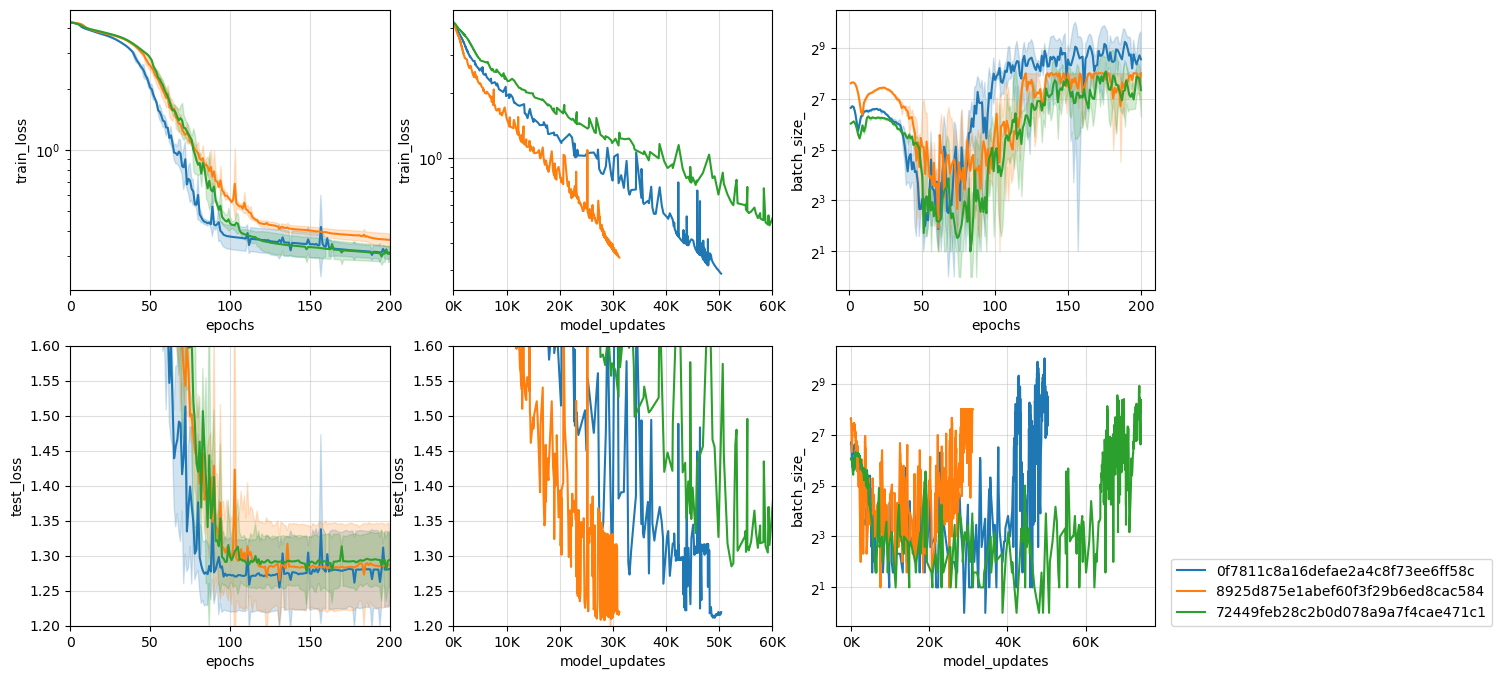

In [123]:
w = 4
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3.5 * w, 2 * w))
for ident, _dfs in best_runs.items():
    show = pd.concat(_dfs).reset_index()
    show["epochs"] = show["epochs"].astype(int)
    # show["model_updates"] = ((show["model_updates"] * 1000).astype(int)) / 1000
    kwargs = dict(data=show, estimator="mean", errorbar="sd")
    # kwargs = dict(data=_dfs[0], errorbar="sd")
    # _df = pd.concat(_dfs)
    for i, loss in enumerate(["train_loss", "test_loss"]):
        for j, time in enumerate(["epochs", "model_updates"]):
            #ax = sns.lineplot(x=time, y=loss, ax=axs[i][j], **kwargs)
            ax = sns.lineplot(x=time, y=loss, ax=axs[i][j], **kwargs)
            if "test" in loss:
                ax.set_ylim(1.2, 1.6)
            if "train" in loss:
                ax.set_yscale("log")
                
            if "updates" in time:
                ax.xaxis.set_major_formatter(lambda x, _: f"{int(x / 1e3)}K")
                ax.set_xlim(0, 60_000)
            if "epochs" in time:
                ax.set_xlim(0,200)
            # ax.set_xlim(0, None)
                # ax.set_xscale("log", base=10)
                # ax.set_xlim(10_000, None)
    for i, time in enumerate(["epochs","model_updates"]):
        kwargs = dict(label=ident) if i == 1 else {}
        ax = sns.lineplot(x=time, y="batch_size_", data=show, ax=axs[i][2], **kwargs)
        if i == 1:
            ax.legend(loc=(1.05, 0))
        ax.set_yscale("log", base=2)
        if "updates" in time:
            ax.xaxis.set_major_formatter(lambda x, _: f"{int(x / 1e3)}K")
for ax in axs.flatten():
    ax.grid(alpha=0.4)

In [9]:
#SWEEPS = Path(".").absolute() / "data-tuning" / "sweep0"
SWEEPS = Path(".").absolute() / "data-tuning" / "sweep"
assert SWEEPS.exists()
dfs = {f.name.replace(".pkl.zip", ""): pd.read_pickle(f) for f in SWEEPS.glob("*.pkl.zip")}

idents = [fname.split("-")[0] for fname in dfs]
print("number of runs for each ident =")
print(pd.Series(idents).value_counts(), "\n")

df = pd.concat(dfs.values()).reset_index()
print(len(df), df.columns)
df.tail()

number of runs for each ident =
af44bea8efa05014b7b5fba94b5724ea    3
5868502dd33dc37651e7baf13df5301e    3
df360dc06a1833040ad5e6ed84dee1a5    3
7042983e60793c001685f23afbddd6e3    3
9b61c8f29d5b3365b2b1b22ecb281fe3    3
                                   ..
f50ec034c79df23fc32fb463102c305f    1
950bfad3eec2f5abf064a55526306c8a    1
fbc23e780dac3995cd882f7a1752164d    1
abd36810bece9c682276effdb26f1812    1
1e55652135dba9e4e755c2a5750573bd    1
Name: count, Length: 294, dtype: int64 

165717 Index(['index', 'epoch_time', 'initial_batch_size', 'max_batch_size',
       'batch_growth_rate', 'dampingfactor', 'dampingdelay', 'epochs',
       'verbose', 'lr', 'no_cuda', 'random_state', 'init_seed', 'damper',
       'dataset', 'approx_loss', 'test_freq', 'rho', 'dwell', 'approx_rate',
       'nesterov', 'momentum', 'weight_decay', 'noisy', 'reduction', 'wait',
       'ident', 'tuning', 'train_x_sum', 'train_y_sum', 'test_x_sum',
       'test_y_sum', 'len_train_x', 'len_train_y', 'len_test_x'

,index,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,...,_epochs,_num_examples,_train_time,damping,_step_time,time,step_time,lr_,batch_size_,norm2
165712,195,1.737229e+09,512,128,0.01,5,20,196.321395,False,0.002217,...,1.0,5376.0,2.680562,150.0,0.051347,1.737229e+09,0.051396,0.001892,128.0,0.692173
165713,196,1.737229e+09,512,128,0.01,5,20,197.329458,False,0.002217,...,1.0,5376.0,2.675467,190.0,0.051231,1.737229e+09,0.051437,0.001493,128.0,0.544595
165714,197,1.737229e+09,512,128,0.01,5,20,198.337521,False,0.002217,...,1.0,5376.0,2.678018,140.0,0.051428,1.737229e+09,0.051496,0.002027,128.0,0.737430
165715,198,1.737229e+09,512,128,0.01,5,20,199.345584,False,0.002217,...,1.0,5376.0,2.676488,159.0,0.051378,1.737229e+09,0.051438,0.001784,128.0,0.649575
165716,199,1.737229e+09,512,128,0.01,5,20,200.353647,False,0.002217,...,NaN,NaN,NaN,145.0,0.051291,1.737229e+09,0.051347,0.001957,128.0,0.714275


In [ ]:
param = 

(1.2, 2.0)

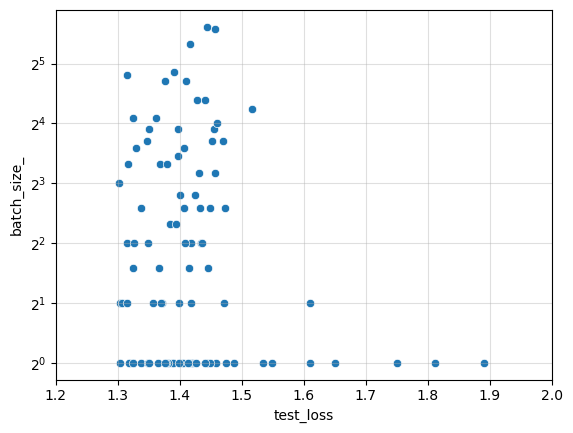

In [13]:
import seaborn as sns
base_dfs = [
    df
    for df in dfs
    if all(
        set(df[k].unique()) == {v} for k, v in BASE.items()
    )
]
assert len(base_dfs) == 1
base_df = base_dfs[0]

ax = sns.scatterplot(
    x="test_loss", y="batch_size_",
    data=base_df,# style="o",
)
ax.grid(alpha=0.4)
ax.set_yscale("log", base=2)
ax.set_xlim(1.2, 2)
# ax.set_ylim(0, 1)

In [14]:
import seaborn as sns
from math import prod
import matplotlib.pyplot as plt
from typing import Dict, Union
# plot lines for dwell

def show_sweep_over(
    sweep: str,
    df: pd.DataFrame,
    base_params: Dict[str, Union[float, int]],
    palette="tab20",
):
    _idx = [df[k] == v for k, v in BASE.items() if k != sweep]
    print(_idx[0].sum())
    idx = prod(_idx).astype(bool)
    print(idx.sum())
    # assert all(idx.sum() > i.sum() for i in _idx)
    show = df[idx].copy().reset_index()
    for k in BASE:
        if k == sweep:
            continue
    #     assert set(show[k].unique()) == {BASE[k]}
    # assert set(show[sweep].unique()) == set(df[sweep].unique())
    
    w = 3
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3 * w, 2 * w))
    kwargs = dict(
        hue=sweep,
        data=show,
        errorbar=None,
        palette=palette,
    )
    sns.lineplot(x="epochs",        y="train_loss", ax=axs[0][0], **kwargs)
    sns.lineplot(x="model_updates", y="train_loss", ax=axs[0][1], **kwargs)
    sns.lineplot(x="model_updates", y="batch_size_", ax=axs[0][2], **kwargs)
    sns.lineplot(x="epochs",        y="test_loss", ax=axs[1][0], **kwargs)
    sns.lineplot(x="model_updates", y="test_loss", ax=axs[1][1], **kwargs)
    sns.lineplot(x="epochs", y="batch_size_", ax=axs[1][2], **kwargs)
    
    
    for i, row in enumerate(axs):
        for k, ax in enumerate(row):
            if i == 0:
                ax.set_title(sweep)
            ax.grid(alpha=0.4)
            if i == 1 and k <= 1:
                ax.set_ylim(1, 2)
            elif i == 0 and k <= 1:
                ax.set_ylim(0, 1.5)
            elif k == 2:
                ax.set_yscale("log", base=2)
    
            if i == 1 and k == 2:
                ax.legend(loc=(1.05, 0))
            else:
                try:
                    ax.legend_.remove()
                except:
                    pass
    return fig, axs

- ibs = [256, 32, 64, 128, 512] # 5
- momentums = [0.6, 0.9, 0.3]  # 3
- dwells = [1, 3, 10, 30, 100] # 5
- rho = [0, 0.05, 0.1, 0.2] # 4
- wait = [10, 100, 1000]  # 3
- mbs = [1024, 2048, 4096] 

19182
101


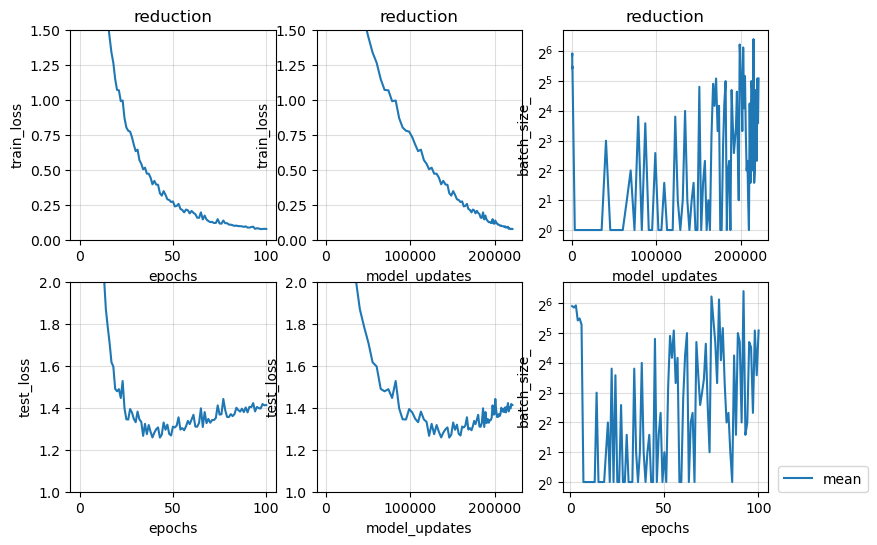

In [55]:
fig, axs = show_sweep_over("reduction", df, BASE, palette="tab20")

19182
101


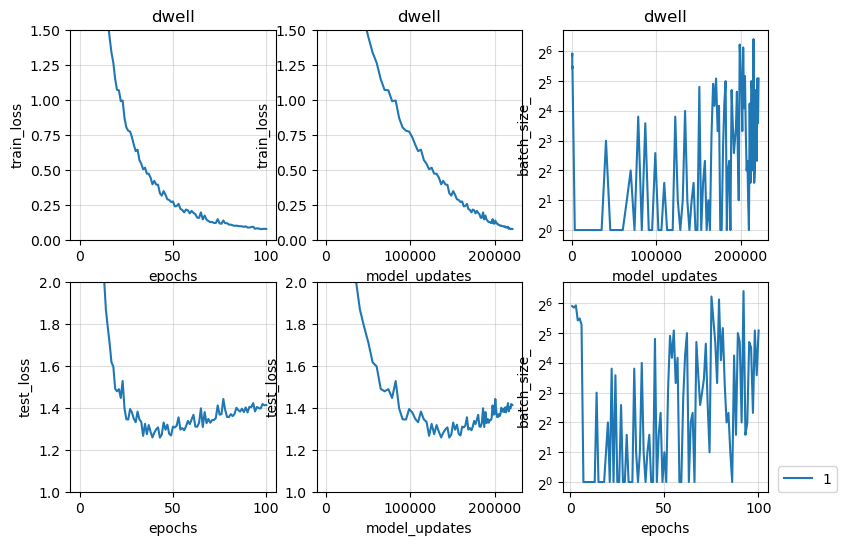

In [56]:
fig, axs = show_sweep_over("dwell", df, BASE, palette="tab20")

19182
101


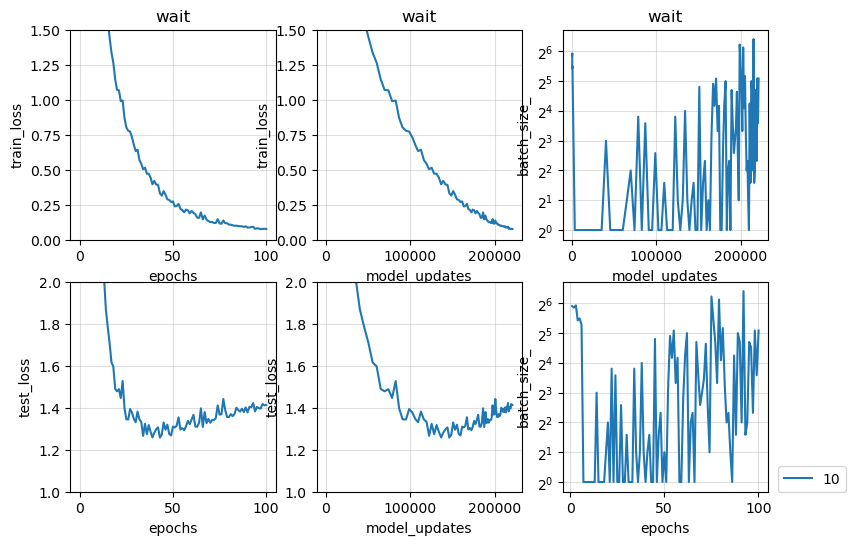

In [57]:
fig, axs = show_sweep_over("wait", df, BASE, palette="tab20")

19182
1201


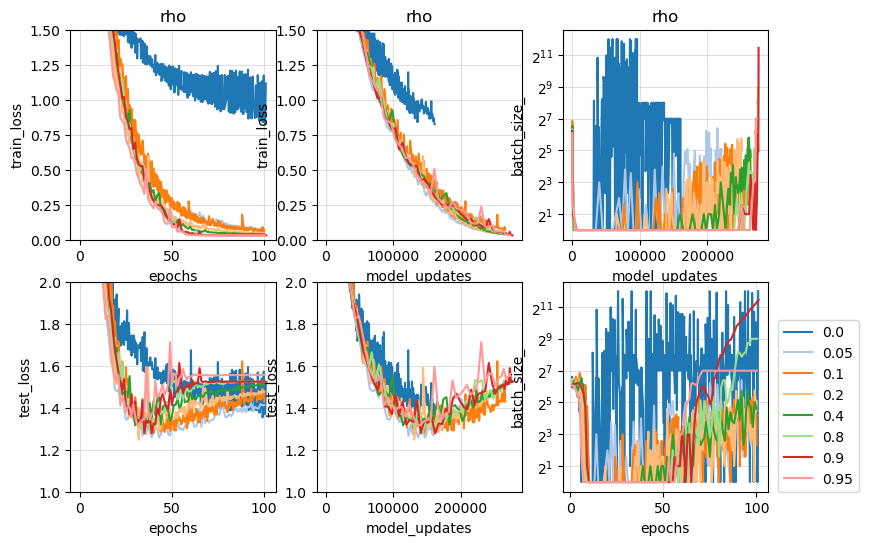

In [58]:
fig, axs = show_sweep_over("rho", df, BASE, palette="tab20")

19182
707


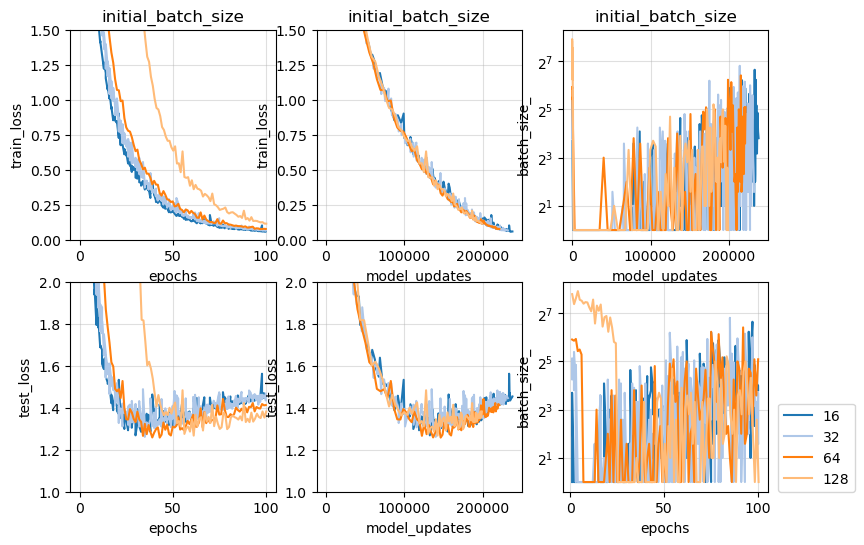

In [59]:
fig, axs = show_sweep_over("initial_batch_size", df, BASE, palette="tab20")

19182
101


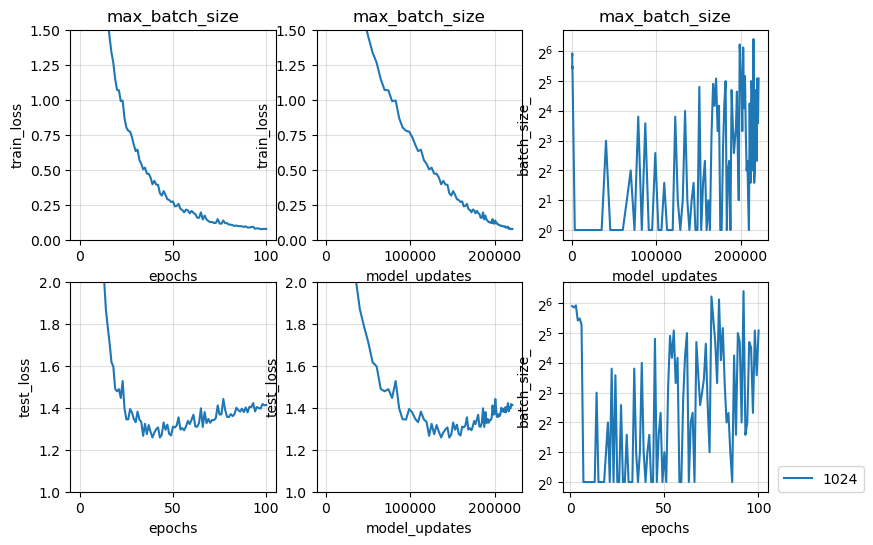

In [60]:
fig, axs = show_sweep_over("max_batch_size", df, BASE, palette="tab20")

58555
303


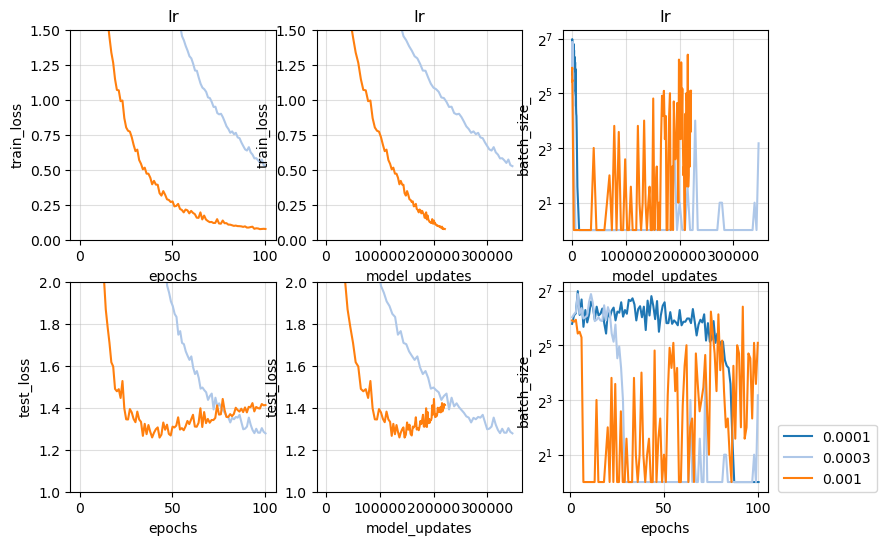

In [61]:
fig, axs = show_sweep_over("lr", df, BASE)

19182
808


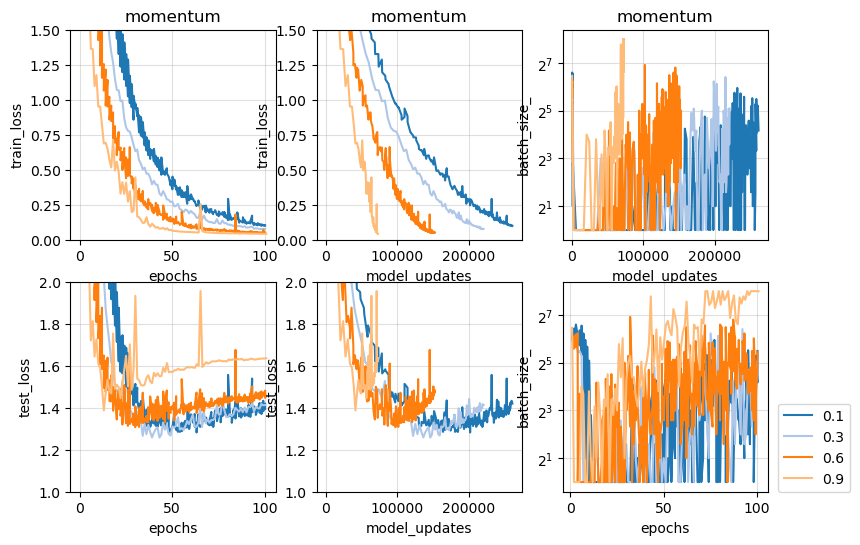

In [62]:
fig, axs = show_sweep_over("momentum", df, BASE)

19182
101


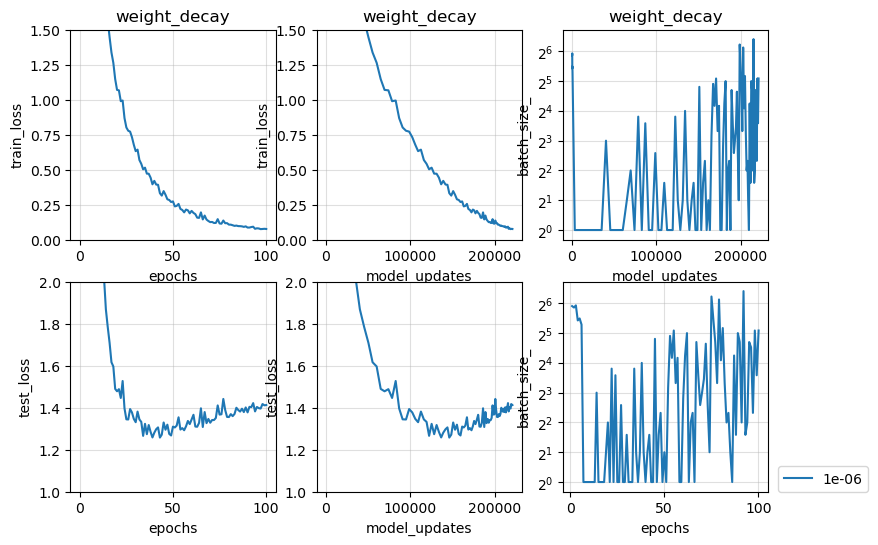

In [63]:
fig, axs = show_sweep_over("weight_decay", df, BASE)